In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.utils import trigonometric_date_encoding, add_seasonality, create_lags, apply_moving_average_for_roc, create_sequences
from dotenv import load_dotenv
import os

In [62]:
# Read in the CSV data
load_dotenv()
AMZN_PATH = str(os.getenv("AMZN_PATH"))
IBM_PATH = str(os.getenv("IBM_PATH"))

amz = pd.read_csv(AMZN_PATH)
ibm = pd.read_csv(IBM_PATH)

In [63]:
def preprocess_data(df):
    # Convert the date column to datetime format
    df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
    df = df.sort_values(by="Date")

    # Extract the year, month, and day as separate columns
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df = df.drop(columns=["Adjusted Close"])
    return df

In [64]:
amz = preprocess_data(amz)
ibm = preprocess_data(ibm)

In [65]:
amz = add_seasonality(amz)
ibm = add_seasonality(ibm)

In [66]:
def split_data(df):
    train_size = int(len(df) * 0.8)
    val_size = int(len(df) * 0.1)
    train = df.iloc[:train_size, :]
    val = df.iloc[train_size : train_size + val_size, :]
    test = df.iloc[train_size + val_size :, :]
    return train, val, test


amz_train, amz_val, amz_test = split_data(amz)
ibm_train, ibm_val, ibm_test = split_data(ibm)

In [67]:
def apply_functions(train, test, val):
    train = apply_moving_average_for_roc(dataframe= train,roc_window= 10)
    test = apply_moving_average_for_roc(dataframe= test,roc_window= 10)
    val = apply_moving_average_for_roc(dataframe= val,roc_window= 10)

    train = create_lags(train, 3)
    test = create_lags(test, 3)
    val = create_lags(val, 3)

    train = trigonometric_date_encoding(train)
    val = trigonometric_date_encoding(val)
    test = trigonometric_date_encoding(test)

    train = train.drop(["Date"], axis=1)
    val = val.drop(["Date"], axis=1)
    test = test.drop(["Date"], axis=1)

    excluded_columns = ["sin_date", "cos_date", "Month_Category_Bearish", "Month_Category_Bullish", "Month_Category_Normal"]
    features_to_standardize = [column for column in train.columns if column not in excluded_columns]


    # Calculate the mean and standard deviation only for the required columns
    train_mean = train[features_to_standardize].mean()
    train_std = train[features_to_standardize].std()

    # Standardize only the required columns in the train, validation, and test sets
    train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
    val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
    test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std

    X_train, y_train = create_sequences(train, 5)
    X_val, y_val = create_sequences(val, 5)
    X_test, y_test = create_sequences(test, 5)

    return X_train, y_train, X_val, y_val, X_test, y_test

amz_X_train, amz_y_train, amz_X_val, amz_y_val, amz_X_test, amz_y_test = apply_functions(amz_train, amz_test, amz_val)
ibm_X_train, ibm_y_train, ibm_X_val, ibm_y_val, ibm_X_test, ibm_y_test = apply_functions(ibm_train, ibm_test, ibm_val)




In [68]:
# print shapes
print("AMZN")
print("X_train shape:", amz_X_train.shape)
print("y_train shape:", amz_y_train.shape)
print("X_val shape:", amz_X_val.shape)
print("y_val shape:", amz_y_val.shape)
print("X_test shape:", amz_X_test.shape)
print("y_test shape:", amz_y_test.shape)
print("IBM")
print("X_train shape:", ibm_X_train.shape)
print("y_train shape:", ibm_y_train.shape)
print("X_val shape:", ibm_X_val.shape)
print("y_val shape:", ibm_y_val.shape)
print("X_test shape:", ibm_X_test.shape)
print("y_test shape:", ibm_y_test.shape)

AMZN
X_train shape: (5144, 5, 19)
y_train shape: (5144,)
X_val shape: (637, 5, 19)
y_val shape: (637,)
X_test shape: (639, 5, 19)
y_test shape: (639,)
IBM
X_train shape: (10678, 5, 19)
y_train shape: (10678,)
X_val shape: (1329, 5, 19)
y_val shape: (1329,)
X_test shape: (1331, 5, 19)
y_test shape: (1331,)


In [69]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_simple_LSTM_regressor(input_shape, output_units=1):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # LSTM layer
    lstm = tfkl.LSTM(16, activation='leaky_relu', return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(16, activation='leaky_relu')(lstm)

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(lstm)  # Single unit for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Simple_LSTM_regressor')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Return the model
    return model


In [70]:
def fit(X_train, y_train, X_val, y_val):
    # Assuming input_shape is (5, n_features)
    input_shape = (X_train.shape[1], X_train.shape[2])  
    output_units = 1

    # Build and compile the model
    model = build_simple_LSTM_regressor(input_shape, output_units)
    model.summary()


    # Train the model
    history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
    ).history

    return model, history

In [71]:
amz_model, amz_history = fit(amz_X_train, amz_y_train, amz_X_val, amz_y_val)

Model: "Simple_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 19)]           0         
                                                                 
 lstm_16 (LSTM)              (None, 5, 16)             2304      
                                                                 
 lstm_17 (LSTM)              (None, 16)                2112      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4433 (17.32 KB)
Trainable params: 4433 (17.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
81/81 [==============================] - 2s 7ms/step - loss: 0.2934 - mae: 0.3517 - val_loss: 6.6541 - val_mae: 2.4498 - lr: 0.0010


In [72]:
ibm_model, ibm_history = fit(ibm_X_train, ibm_y_train, ibm_X_val, ibm_y_val)

Model: "Simple_LSTM_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 19)]           0         
                                                                 
 lstm_18 (LSTM)              (None, 5, 16)             2304      
                                                                 
 lstm_19 (LSTM)              (None, 16)                2112      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4433 (17.32 KB)
Trainable params: 4433 (17.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
167/167 [==============================] - 3s 5ms/step - loss: 0.1037 - mae: 0.2142 - val_loss: 0.0321 - val_mae: 0.1427 - lr: 0.001

In [73]:
def evaluate(model, X_test, y_test):
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


20/20 [==============================] - 0s 2ms/step


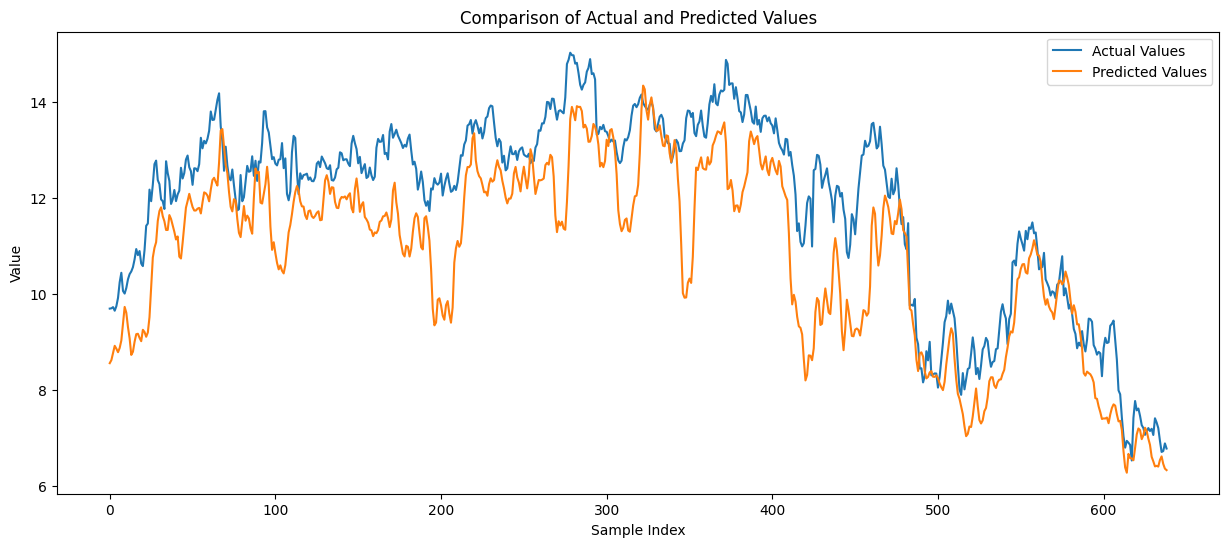

In [74]:
evaluate(amz_model, amz_X_test, amz_y_test)

42/42 [==============================] - 0s 1ms/step


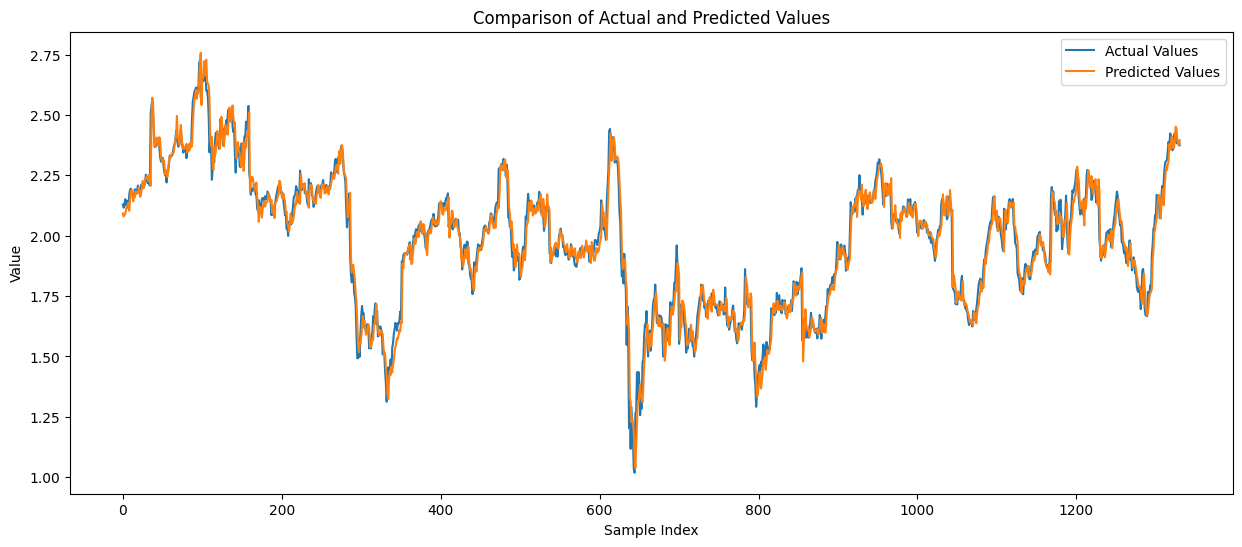

In [75]:
evaluate(ibm_model, ibm_X_test, ibm_y_test)